In [1]:
import findspark

findspark.init()

In [11]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("select 'spark' as hello")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [12]:
df = spark.read.csv("toy_dataset.csv", inferSchema=True, header=True)
df.show()
df.printSchema()

+------+------+------+---+-------+-------+
|Number|  City|Gender|Age| Income|Illness|
+------+------+------+---+-------+-------+
|     1|Dallas|  Male| 41|40367.0|     No|
|     2|Dallas|  Male| 54|45084.0|     No|
|     3|Dallas|  Male| 42|52483.0|     No|
|     4|Dallas|  Male| 40|40941.0|     No|
|     5|Dallas|  Male| 46|50289.0|     No|
|     6|Dallas|Female| 36|50786.0|     No|
|     7|Dallas|Female| 32|33155.0|     No|
|     8|Dallas|  Male| 39|30914.0|     No|
|     9|Dallas|  Male| 51|68667.0|     No|
|    10|Dallas|Female| 30|50082.0|     No|
|    11|Dallas|Female| 48|41524.0|    Yes|
|    12|Dallas|  Male| 47|54777.0|     No|
|    13|Dallas|  Male| 46|62749.0|     No|
|    14|Dallas|Female| 42|50894.0|     No|
|    15|Dallas|Female| 61|38429.0|     No|
|    16|Dallas|  Male| 43|34074.0|     No|
|    17|Dallas|  Male| 27|50398.0|     No|
|    18|Dallas|  Male| 38|46373.0|    Yes|
|    19|Dallas|  Male| 47|51137.0|     No|
|    20|Dallas|Female| 35|23688.0|     No|
+------+---

## How Many Records?

In [7]:
df.count()

150000

## How many Total Males?

In [15]:
print(df.filter(df.Gender == "Male").count())
print(df.where(df.Gender == "Male").count())

83800
83800


In [21]:
df2 = df.sample(0.01)
df2.show()

+------+------+------+---+-------+-------+
|Number|  City|Gender|Age| Income|Illness|
+------+------+------+---+-------+-------+
|    63|Dallas|Female| 54|36552.0|     No|
|    66|Dallas|Female| 53|40244.0|     No|
|   271|Dallas|  Male| 47|43823.0|     No|
|   389|Dallas|  Male| 42|65963.0|     No|
|   495|Dallas|  Male| 29|55608.0|     No|
|   930|Dallas|Female| 25|38943.0|     No|
|   970|Dallas|  Male| 62|54903.0|     No|
|  1166|Dallas|  Male| 49|53156.0|     No|
|  1167|Dallas|Female| 54|31292.0|     No|
|  1525|Dallas|  Male| 38|33051.0|     No|
|  1635|Dallas|  Male| 33|44051.0|     No|
|  1667|Dallas|Female| 64|41046.0|     No|
|  1732|Dallas|Female| 33|33275.0|     No|
|  1759|Dallas|Female| 30|54870.0|     No|
|  1820|Dallas|  Male| 54|64900.0|     No|
|  1884|Dallas|  Male| 52|42129.0|     No|
|  1925|Dallas|Female| 54|39058.0|     No|
|  1932|Dallas|Female| 59|39407.0|    Yes|
|  1939|Dallas|  Male| 27|60077.0|     No|
|  2062|Dallas|  Male| 34|68562.0|     No|
+------+---

## How many people live in each city?

In [23]:
cities = df.groupBy("City").count().count()
df.groupBy("City").count().show()

+---------------+-----+
|           City|count|
+---------------+-----+
|         Dallas|19707|
|    Los Angeles|32173|
|  New York City|50307|
|  Mountain View|14219|
|      San Diego| 4881|
|         Austin|12292|
|Washington D.C.| 8120|
|         Boston| 8301|
+---------------+-----+



## How many people are ill vs not ill?

In [32]:
illPeople = df.filter(df.Illness == "Yes").count()
notIll = df.count() - illPeople
print(f"Ill = {illPeople}, notIll = {notIll}")

df2 = df.groupBy("Illness").count()
df2.show()

Ill = 12139, notIll = 137861
+-------+------+
|Illness| count|
+-------+------+
|     No|137861|
|    Yes| 12139|
+-------+------+



In [35]:
rows = df2.select("count").collect()
rows[0][0]

137861

## How many Males vs Females?

Female = 66200, Males = 83800
Male (55.87%) : Female (44.13%)


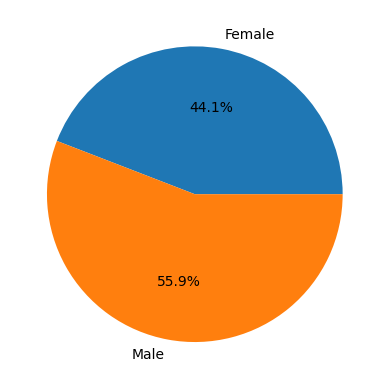

In [52]:
import matplotlib.pyplot as plt
data = df.groupBy("Gender").count().select("count").collect()
females, males = data[0][0], data[1][0]
total = females + males

print(f"Female = {females}, Males = {males}")

percentFemale = (females / total) * 100
percentMale = (males / total) * 100

print(f"Male ({percentMale:.4}%) : Female ({percentFemale:.4}%)")


plt.pie([percentFemale, percentMale], labels=["Female", "Male"], autopct="%1.1f%%")
plt.show()


# Are there more ill men than women?

In [53]:
df2 = df.where(df.Illness=="Yes").groupBy(df.Gender).count()
df2.show()

+------+-----+
|Gender|count|
+------+-----+
|Female| 5331|
|  Male| 6808|
+------+-----+



# Which City has the most ill people?

In [73]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, asc, desc

df2 = df.where(df.Illness == "Yes").groupBy(df.City).count().sort(col("count").desc())
df2.take(1)

[Row(City='New York City', count=4021)]

# Do Ill people earn less on average than not ill?

In [78]:
from pyspark.sql.functions import mean

avgill = df.filter(df.Illness == "No").select(mean("Income")).withColumnRenamed("avg(Income)", "Mean Healthy Income")
avghealthy = df.filter(df.Illness == "Yes").select(mean("Income")).withColumnRenamed("avg(Income)", "Mean Unwell Income")
avgill.join(avghealthy).show(vertical=True)


-RECORD 0--------------------------------
 Mean Healthy Income | 91250.59017416093 
 Mean Unwell Income  | 91277.8753604086  



# What is the mean age for ill people?

In [81]:
df.filter(df.Illness == "Yes").select("Age").summary().show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|             12139|
|   mean| 45.02084191449048|
| stddev|11.554129904969162|
|    min|                25|
|    25%|                35|
|    50%|                45|
|    75%|                55|
|    max|                65|
+-------+------------------+



# Where does the oldest non ill person live?

In [87]:
from pyspark.sql.functions import max

df.filter(df.Illness == "No").sort(col("Age").desc()).show(n=4)
df.select(max("Age")).show()

+------+-------------+------+---+--------+-------+
|Number|         City|Gender|Age|  Income|Illness|
+------+-------------+------+---+--------+-------+
|109331|Mountain View|Female| 65|141513.0|     No|
|   405|       Dallas|  Male| 65| 54304.0|     No|
|109679|Mountain View|  Male| 65|138095.0|     No|
|   715|       Dallas|Female| 65| 37573.0|     No|
+------+-------------+------+---+--------+-------+
only showing top 4 rows

+--------+
|max(Age)|
+--------+
|      65|
+--------+



# Animal Dataset

In [116]:
import requests as req
import json

res = req.get("https://apps.des.qld.gov.au/species/?op=getfamilynames&kingdom=animals&class=actinopterygii")
data = json.loads(res.text)
with open("data.json", "w") as file:
    json.dump(data["Family"], file)

print(data["Family"])

[{'KingdomName': 'Animalia', 'KingdomCommonName': 'animals', 'ClassName': 'Actinopterygii', 'ClassCommonName': 'ray-finned fishes', 'FamilyName': 'Acanthuridae', 'FamilyCommonName': 'surgeonfishes', 'FamilyRank': '950882', 'SpeciesUrl': 'http://apps.des.qld.gov.au/species/?op=getspecies&family=acanthuridae'}, {'KingdomName': 'Animalia', 'KingdomCommonName': 'animals', 'ClassName': 'Actinopterygii', 'ClassCommonName': 'ray-finned fishes', 'FamilyName': 'Adrianichthyidae', 'FamilyCommonName': 'adrianichthyids', 'FamilyRank': '950448', 'SpeciesUrl': 'http://apps.des.qld.gov.au/species/?op=getspecies&family=adrianichthyidae'}, {'KingdomName': 'Animalia', 'KingdomCommonName': 'animals', 'ClassName': 'Actinopterygii', 'ClassCommonName': 'ray-finned fishes', 'FamilyName': 'Alestidae', 'FamilyCommonName': 'African tetras', 'FamilyRank': '950108', 'SpeciesUrl': 'http://apps.des.qld.gov.au/species/?op=getspecies&family=alestidae'}, {'KingdomName': 'Animalia', 'KingdomCommonName': 'animals', 'Cla

In [123]:
df = spark.read.json("data.json")
df.printSchema()
df.show()
df.count()

root
 |-- ClassCommonName: string (nullable = true)
 |-- ClassName: string (nullable = true)
 |-- FamilyCommonName: string (nullable = true)
 |-- FamilyName: string (nullable = true)
 |-- FamilyRank: string (nullable = true)
 |-- KingdomCommonName: string (nullable = true)
 |-- KingdomName: string (nullable = true)
 |-- SpeciesUrl: string (nullable = true)

+-----------------+--------------+--------------------+------------------+----------+-----------------+-----------+--------------------+
|  ClassCommonName|     ClassName|    FamilyCommonName|        FamilyName|FamilyRank|KingdomCommonName|KingdomName|          SpeciesUrl|
+-----------------+--------------+--------------------+------------------+----------+-----------------+-----------+--------------------+
|ray-finned fishes|Actinopterygii|       surgeonfishes|      Acanthuridae|    950882|          animals|   Animalia|http://apps.des.q...|
|ray-finned fishes|Actinopterygii|     adrianichthyids|  Adrianichthyidae|    950448|       

80

In [122]:
fish = df.filter(df.ClassName == "Actinopterygii")
fish.count()

80